# Deep Recommender: Neural Colaborative Filtering

In this tutorial, we demostrate how a basic matrix factorization algorithm can be replicated using a neural network. We next extend this basic network to incorporate item features (embeddings) extracted using a pre-trained NLP model.

### Data
We use **MovieLens 20M** dataset (see **datasets.md** for details).

In [1]:
import os
import numpy as np
import pandas as pd
import random
import warnings
from tabulate import tabulate

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dot, Flatten, Concatenate, Add
from sklearn.model_selection import train_test_split

from sentence_transformers import SentenceTransformer

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
warnings.simplefilter("ignore")

print("Keras version " + tf.keras.__version__)
print("Tensorflow version " + tf.__version__)

Keras version 2.6.0
Tensorflow version 2.6.0


In [2]:
#
# Helper functions
#
def print_df(df, col_width = 10, rows = 10, max_cols = 10):
    def short_srt(x):
        return x if len(x) < col_width else x[:col_width-3] + "..."
    df_short = df.head(rows).applymap(lambda x: short_srt(str(x)))
    
    if len(df_short.columns) > max_cols:
        df_short = df_short.iloc[:, 0:max_cols-1]
        df_short['...'] = '...'
    
    print(tabulate(df_short, headers='keys', tablefmt='psql'))
    print(f'{len(df)} rows x {len(df.columns)} columns')
    
def plot_keras_training_hitory(history):
    plt.plot(history.history['loss']);
    plt.plot(history.history['val_loss']);
    plt.xlabel('Training epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid(True)

# Load Data

Load movie ratings and tags from the MovieLens 10M dataset.

In [3]:
#
# Raw data
# 
base_data_path = 'ml-20m'
items = pd.read_csv(base_data_path + '/movies.csv', sep=',', skiprows=1, 
                     names=['item_id', 'title', 'genres'])
ratings = pd.read_csv(base_data_path + '/ratings.csv', sep=',', skiprows=1,
                      names=['user_id', 'item_id', 'rating', 'timestamp'])
tags = pd.read_csv(base_data_path + '/tags.csv', sep=',', skiprows=1,
                      names=['user_id', 'item_id', 'tag', 'timestamp'])

#
# Concatenate tags
#
tags_flat = tags[['item_id', 'tag']]\
    .groupby(by=['item_id'])['tag']\
    .apply(list)\
    .apply(lambda x: ' '.join(list(map(str, x))))\
    .apply(str.lower)
items = items.join(tags_flat, on='item_id')

#
# Preprocessing
#

# Remove movies with short tag lines
items = items[items['tag'].str.len() > 200]
ratings = ratings[ratings['item_id'].isin(items['item_id'].unique())] 
# Remove users with less than 50 ratings
ratings = ratings[ratings.groupby(by='user_id')['user_id'].transform('size') > 50] 
ratings['rating'] = ratings['rating'].round(0).astype(int)

# Remap user and item IDs to sequental integers 
n_users, n_items = ratings['user_id'].nunique(), ratings['item_id'].nunique()
item_id_lookup = { old_id:new_id for (old_id, new_id) in zip(items['item_id'].values, np.arange(n_items)) }
items['item_id'] = items['item_id'].apply(lambda x: item_id_lookup[x])
ratings['item_id'] = ratings['item_id'].apply(lambda x: item_id_lookup[x])

user_id_lookup = { old_id:new_id for (old_id, new_id) in zip(ratings['user_id'].unique(), np.arange(n_users)) }
ratings['user_id'] = ratings['user_id'].apply(lambda x: user_id_lookup[x])

print_df(items, col_width = 30)
print_df(ratings)

#
# Calculate statistics and limits
#
user_ids, item_ids = ratings['user_id'].unique(), ratings['item_id'].unique()
max_user_id, max_item_id = max(ratings['user_id']), max(ratings['item_id'])
print(f'Max user id: {max_user_id}, max item id: {max_item_id}')

+----+-----------+--------------------------------+--------------------------------+--------------------------------+
|    |   item_id | title                          | genres                         | tag                            |
|----+-----------+--------------------------------+--------------------------------+--------------------------------|
|  0 |         0 | Toy Story (1995)               | Adventure|Animation|Childre... | watched computer animation ... |
|  1 |         1 | Jumanji (1995)                 | Adventure|Children|Fantasy     | time travel adapted from:bo... |
|  2 |         2 | Grumpier Old Men (1995)        | Comedy|Romance                 | old people that is actually... |
|  4 |         3 | Father of the Bride Part II... | Comedy                         | diane keaton family sequel ... |
|  5 |         4 | Heat (1995)                    | Action|Crime|Thriller          | realistic action al pacino ... |
|  6 |         5 | Sabrina (1995)                 | Come

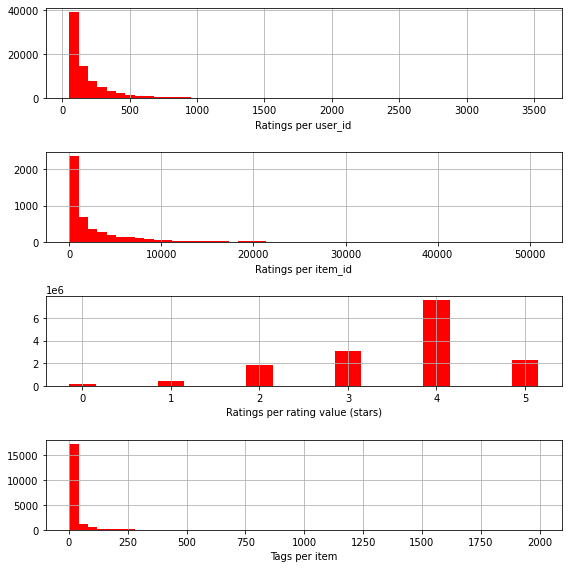

In [6]:
#
# Visualize the main statistics
#
fig, ax = plt.subplots(4, 1, figsize=(8, 8) )
for i, c in enumerate(['user_id', 'item_id']):
    sns.distplot(ratings.groupby(by=[c]).count().iloc[:, 0].values, kde=False, ax=ax[i], 
                 axlabel=f'Ratings per {c}', color='red', hist_kws=dict(alpha=1))
    ax[i].grid(True)
    
rating_frequencies = ratings.groupby(by=['rating']).count().iloc[:, 0]
ax[2].bar(rating_frequencies.index, rating_frequencies, color='red', width=.3)
ax[2].grid(True)
ax[2].set_xlabel('Ratings per rating value (stars)')
plt.tight_layout()

tag_frequencies = tags.groupby(by=['item_id']).count().iloc[:, 0].values
sns.distplot(tag_frequencies, kde=False, ax=ax[3], 
                 axlabel=f'Tags per item', color='red', hist_kws=dict(alpha=1))
ax[3].grid(True)
plt.tight_layout()

In [4]:
#
# Fix the train-test split
#
n = ratings.shape[0]
train_idx, test_idx, _, _ = train_test_split(np.arange(n), np.arange(n), test_size=0.20, random_state=42)

# Model 1: Neural Collaborative Filtering (Factorization Network)

In this section, we train and evaluate a basic network that replicates the standard matrix factorization algorithm.

Epoch 1/16
47889/47889 [==============================] - 94s 2ms/step - loss: 0.8033 - root_mean_squared_error: 0.8962 - val_loss: 0.6982 - val_root_mean_squared_error: 0.8356
Epoch 2/16
47889/47889 [==============================] - 94s 2ms/step - loss: 0.6698 - root_mean_squared_error: 0.8184 - val_loss: 0.6734 - val_root_mean_squared_error: 0.8206
Epoch 3/16
47889/47889 [==============================] - 93s 2ms/step - loss: 0.6491 - root_mean_squared_error: 0.8056 - val_loss: 0.6664 - val_root_mean_squared_error: 0.8164
Epoch 4/16
47889/47889 [==============================] - 93s 2ms/step - loss: 0.6404 - root_mean_squared_error: 0.8002 - val_loss: 0.6814 - val_root_mean_squared_error: 0.8255
Epoch 5/16
47889/47889 [==============================] - 94s 2ms/step - loss: 0.6354 - root_mean_squared_error: 0.7971 - val_loss: 0.6820 - val_root_mean_squared_error: 0.8258
Epoch 6/16
47889/47889 [==============================] - 93s 2ms/step - loss: 0.6323 - root_mean_squared_error: 0.

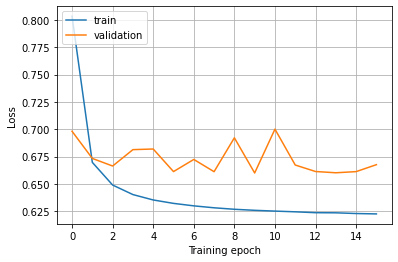

In [11]:
x_train, x_test = ratings[['user_id', 'item_id']].values[train_idx], ratings[['user_id', 'item_id']].values[test_idx]
y_train, y_test = ratings['rating'].values[train_idx], ratings['rating'].values[test_idx]

#
# Model specification
#
embedding_dim = 8

input_user = Input(shape=(1,))
input_item = Input(shape=(1,))

embedding_user = Embedding(input_dim=max_user_id + 1, output_dim=embedding_dim)(input_user)
embedding_item = Embedding(input_dim=max_item_id + 1, output_dim=embedding_dim)(input_item)

combined = Dot(axes=2)([embedding_user, embedding_item])

score = Dense(1, activation='linear')(combined)

model_sgd = Model(inputs=[input_user, input_item], outputs=score)

#
# Model training
#
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model_sgd.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()]) 
history_sgd = model_sgd.fit([x_train[:, 0], x_train[:, 1]], y_train, 
                    batch_size=256, epochs=16, verbose=1, 
                    validation_data=([x_test[:, 0], x_test[:, 1]], y_test)) 

plot_keras_training_hitory(history_sgd)

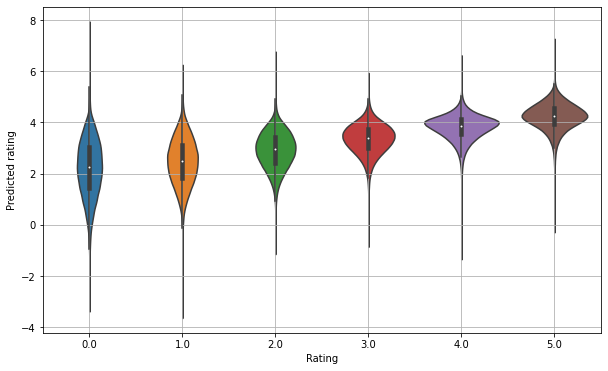

In [12]:
y_test_hat = model_sgd.predict([x_test[:, 0], x_test[:, 1]])[:, 0, 0]
plot_data = pd.DataFrame(np.vstack([y_test, y_test_hat]).T, columns=['Rating', 'Predicted rating'])
fig, ax = plt.subplots(1, figsize=(10, 6))
sns.violinplot(data=plot_data, x = "Rating", y = "Predicted rating", ax=ax)
plt.grid(True)

In [14]:
def get_items(user_id):
    u_items = ratings[ratings['user_id'] == user_id].merge(items, on='item_id', how='left')
    return u_items[['title', 'rating']].sort_values(by=['rating'], ascending=False)

def recommend_for_user(model, user_id, k):
    x1, x2 = np.repeat(user_id, n_items), item_ids
    ratings = model.predict([x1, x2]).ravel()
    top_k_indexes = ratings.argsort()[-k:][::-1]
    return x2[top_k_indexes], ratings[top_k_indexes]

def show_recommendations(r_items, r_ratings):
    r = pd.DataFrame(data=np.vstack([r_items, r_ratings]).T, columns=['item_id', 'rating'])
    print_df(r.merge(items, on='item_id', how='left')[['title', 'rating']], col_width = 50)

#
# Generate recommendations for an example user
#
user_id = 0
k_recomendations = 10
print_df(get_items(user_id), col_width = 50, rows = 10)
r_items, r_ratings = recommend_for_user(model_sgd, user_id, k_recomendations)
show_recommendations(r_items, r_ratings)

+-----+----------------------------------------------------+----------+
|     | title                                              |   rating |
|-----+----------------------------------------------------+----------|
| 121 | Lord of the Rings: The Fellowship of the Ring, ... |        5 |
| 155 | Freaks (1932)                                      |        5 |
| 131 | Lord of the Rings: The Two Towers, The (2002)      |        5 |
| 145 | Lord of the Rings: The Return of the King, The ... |        5 |
|   0 | Jumanji (1995)                                     |        4 |
| 106 | O Brother, Where Art Thou? (2000)                  |        4 |
| 100 | Hook (1991)                                        |        4 |
| 101 | Misery (1990)                                      |        4 |
| 103 | Crouching Tiger, Hidden Dragon (Wo hu cang long... |        4 |
| 104 | Dungeons & Dragons (2000)                          |        4 |
+-----+----------------------------------------------------+----

# Model 2: Network with Item Features

In this section, we build a simple extension of the basic neural collaborative filtering network to incroporate embeddigns produced based movie tags. 

We create item embeddigns by concatenating all movie tags into pseudo-sentence and encoding it using a pre-trained MiniLM model.

In [5]:
text_model = SentenceTransformer('all-MiniLM-L6-v2')
items['item_features'] = items['tag'].transform(text_model.encode)

item_features_r = ratings.merge(items[['item_id', 'item_features']], on='item_id')['item_features']
item_features_r = np.vstack(item_features_r)
print(f'Item features shape: {item_features_r.shape}')
feature_dim = item_features_r.shape[1]

x1_train, x2_train, x3_train = ratings['user_id'].values[train_idx], ratings['item_id'].values[train_idx], item_features_r[train_idx]
x1_test, x2_test, x3_test = ratings['user_id'].values[test_idx], ratings['item_id'].values[test_idx], item_features_r[test_idx]
y_train, y_test = ratings['rating'].values[train_idx], ratings['rating'].values[test_idx]

del item_features_r

Item features shape: (15324463, 384)


Epoch 1/16
47889/47889 [==============================] - 105s 2ms/step - loss: 0.9548 - root_mean_squared_error: 0.9771 - val_loss: 0.7311 - val_root_mean_squared_error: 0.8550
Epoch 2/16
47889/47889 [==============================] - 100s 2ms/step - loss: 0.6958 - root_mean_squared_error: 0.8342 - val_loss: 0.6848 - val_root_mean_squared_error: 0.8275
Epoch 3/16
47889/47889 [==============================] - 100s 2ms/step - loss: 0.6582 - root_mean_squared_error: 0.8113 - val_loss: 0.6700 - val_root_mean_squared_error: 0.8185
Epoch 4/16
47889/47889 [==============================] - 99s 2ms/step - loss: 0.6395 - root_mean_squared_error: 0.7997 - val_loss: 0.6619 - val_root_mean_squared_error: 0.8136
Epoch 5/16
47889/47889 [==============================] - 99s 2ms/step - loss: 0.6288 - root_mean_squared_error: 0.7930 - val_loss: 0.6579 - val_root_mean_squared_error: 0.8111
Epoch 6/16
47889/47889 [==============================] - 99s 2ms/step - loss: 0.6223 - root_mean_squared_error:

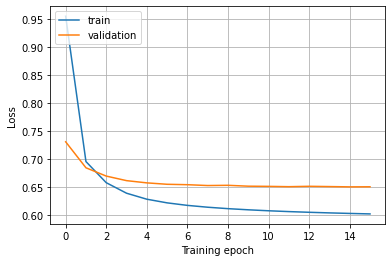

In [6]:
def model_hybrid(embedding_dim):
    input_user = Input(shape=(1,))
    input_item = Input(shape=(1,))
    input_item_e = Input(shape=(feature_dim,))
    
    embedding_user = Embedding(input_dim=max_user_id + 1, output_dim=embedding_dim)(input_user)
    embedding_item = Embedding(input_dim=max_item_id + 1, output_dim=embedding_dim)(input_item)

    #e1 = Flatten()(embedding_user)
    #e2 = Flatten()(embedding_item)
    e1 = embedding_user
    e2 = embedding_item
    
    t = Dense(embedding_dim, activation='relu')(input_item_e)
    e2 = Add()([e2, t])
    #e2 = Dense(embedding_dim, activation='relu')(e2)

    combined = Dot(axes=2)([e1, e2])
    rating = Dense(1, activation='linear')(combined)

    model = Model(inputs=[input_user, input_item, input_item_e], outputs=rating)
    
    return model

#
# Model training
# 
model_hybrid_k = model_hybrid(embedding_dim = 8)
model_hybrid_k.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()]) 
history_hybrid = model_hybrid_k.fit([x1_train, x2_train, x3_train], y_train, 
                           batch_size=256, 
                           epochs=16, 
                           validation_data=([x1_test, x2_test, x3_test], y_test), 
                           verbose=1)
plot_keras_training_hitory(history_hybrid)

In [9]:
def recommend_for_user_hybrid(model, user_id, k):
    x1, x2, x3 = np.repeat(user_id, n_items), item_ids, np.vstack(items['item_features'].values)
    ratings = model.predict([x1, x2, x3]).ravel()
    top_k_indexes = ratings.argsort()[-k:][::-1]
    return x2[top_k_indexes], ratings[top_k_indexes]

#
# Generate recommendations for an example user
#
user_id = 0
k_recomendations = 10
print_df(get_items(user_id), col_width = 50, rows = 10)
r_items, r_ratings = recommend_for_user_hybrid(model_hybrid_k, user_id, k_recomendations)
show_recommendations(r_items, r_ratings)

+-----+----------------------------------------------------+----------+
|     | title                                              |   rating |
|-----+----------------------------------------------------+----------|
| 121 | Lord of the Rings: The Fellowship of the Ring, ... |        5 |
| 155 | Freaks (1932)                                      |        5 |
| 131 | Lord of the Rings: The Two Towers, The (2002)      |        5 |
| 145 | Lord of the Rings: The Return of the King, The ... |        5 |
|   0 | Jumanji (1995)                                     |        4 |
| 106 | O Brother, Where Art Thou? (2000)                  |        4 |
| 100 | Hook (1991)                                        |        4 |
| 101 | Misery (1990)                                      |        4 |
| 103 | Crouching Tiger, Hidden Dragon (Wo hu cang long... |        4 |
| 104 | Dungeons & Dragons (2000)                          |        4 |
+-----+----------------------------------------------------+----